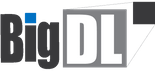

# Introduction
In this notebook we demonstrates how to train forecaster on one node.

### Why we need to train a forecaster? 
To learn the pattern (like the period, scale...) in history data.

### Hardware support
Chronos only support CPU training (and acceleration on Intel CPU) for training. Since time series data is not large, CPU training is enough for most cases.

# Step1: Data preparation
We support 3 data representations:

### TSDataset

Forecaster will automatically process the TSDataset. By default, TSDataset will be transformed to a pytorch dataloader, which is memory-friendly while a little bit slower.  
Users may call `roll` on the TSDataset before calling `fit`. Then the training speed will be faster but will consume more memory.  

Below cell shows how to generate the TSDataset.

In [ ]:
import numpy as np
def create_tsdataset(roll=True, horizon=5):
    from bigdl.chronos.data import TSDataset
    import pandas as pd
    timeseries = pd.date_range(start='2020-01-01', freq='D', periods=1000)
    df = pd.DataFrame(np.random.rand(1000, 2),
                      columns=['value1', 'value2'],
                      index=timeseries)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'timeseries'}, inplace=True)
    train, _, test = TSDataset.from_pandas(df=df,
                                           dt_col='timeseries',
                                           target_col=['value1', 'value2'],
                                           with_split=True)
    if roll:
        for tsdata in [train, test]:
            tsdata.roll(lookback=24, horizon=horizon)
    return train, test
train, test = create_tsdataset()

### Numpy Ndarray

x's shape is (num_samples, lookback, feature_dim) where lookback and feature_dim should be the same as past_seq_len and input_feature_num.  
y's shape is (num_samples, horizon, target_dim), where horizon and target_dim should be the same as future_seq_len and output_feature_num.

Below two cells show how to generate the Numpy Ndarray using either pytorch or tensorflow.

In [ ]:
import numpy as np
import torch
def create_data(loader=False):
    num_train_samples = 1000
    num_val_samples = 400
    num_test_samples = 400
    input_time_steps = 24
    input_feature_dim = 1
    output_time_steps = 5
    output_feature_dim = 1

    def get_x_y(num_samples):
        x = np.random.rand(num_samples, input_time_steps, input_feature_dim).astype(np.float32)
        y = x[:, -output_time_steps:, :]*2 + \
            np.random.rand(num_samples, output_time_steps, output_feature_dim).astype(np.float32)
        return x, y

    train_data = get_x_y(num_train_samples)
    val_data = get_x_y(num_val_samples)
    test_data = get_x_y(num_test_samples)

    if loader:
        from torch.utils.data import DataLoader, TensorDataset
        train_loader = DataLoader(TensorDataset(torch.from_numpy(train_data[0]),
                                                torch.from_numpy(train_data[1])), batch_size=32)
        val_loader = DataLoader(TensorDataset(torch.from_numpy(val_data[0]),
                                              torch.from_numpy(val_data[1])), batch_size=32)
        test_loader = DataLoader(TensorDataset(torch.from_numpy(test_data[0]),
                                               torch.from_numpy(test_data[1])), batch_size=32)
        return train_loader, val_loader, test_loader
    else:
        return train_data, val_data, test_data
train_data, val_data, test_data = create_data()

In [ ]:
import numpy as np
import tensorflow as tf
def create_data(tf_data=False, batch_size=32):
    train_num_samples = 1000
    test_num_samples = 400
    input_feature_num = 10
    output_feature_num = 2
    past_seq_len = 10
    
    def get_x_y(num_sample):
        x = np.random.randn(num_sample, past_seq_len, input_feature_num)
        y = np.random.randn(num_sample, 1, output_feature_num)
        return x, y
    
    train_data = get_x_y(train_num_samples)
    test_data = get_x_y(test_num_samples)

    if tf_data:
        from_tensor_slices = tf.data.Dataset.from_tensor_slices
        train_data = from_tensor_slices(train_data).cache()\
                                                   .shuffle(train_num_samples)\
                                                   .batch(batch_size)\
                                                   .prefetch(tf.data.AUTOTUNE)
        test_data = from_tensor_slices(test_data).cache()\
                                                 .batch(batch_size)\
                                                 .prefetch(tf.data.AUTOTUNE)
    return train_data, test_data
train_data, test_data = create_data()

### pytorch dataloader / tf dataset

The dataloader and TFDataset should return x, y in each iteration with the shape as following:  
x's shape is (num_samples, lookback, feature_dim) where lookback and feature_dim should be the same as past_seq_len and input_feature_num.  
y's shape is (num_samples, horizon, target_dim), where horizon and target_dim should be the same as future_seq_len and output_feature_num.


Below two cells show how to generate the pytorch dataloader or tf dataset.

In [ ]:
train_loader, val_loader, test_loader = create_data(loader=True)

In [ ]:
train_data, test_data = create_data(tf_data=True)

# Step2: Training

### fit
We can train model by calling `fit` with no validation data.  
Input the following 3 parameters: `data`, `epochs`, and `batch_size`.  
The validation_step in the training loop will be skipped.`fit` has no return value in this way.


In [ ]:
from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster
train_data, val_data, test_data = create_data()
forecaster = TCNForecaster(past_seq_len=24,
                           future_seq_len=5,
                           input_feature_num=1,
                           output_feature_num=1,
                           kernel_size=4,
                           num_channels=[16, 16],
                           loss="mae",
                           lr=0.01)
forecaster.fit(train_data, epochs=20)

### validation
We can also call fit while having validation data.  
Input the following 6 parameters: `data`, `validation_data`, `epochs`, `batch_size`, `validation_mode`, and `earlystop_patience`.  
The validation_step in the training loop will be executed. And in this way, you need to input `validation_mode` to select the operation you want.  
The `validation_mode` includes the following types: `output`, `earlystop`, and `best_epoch`.  
`fit` will return a dict recording the average validation loss of each epoch in this way.  

In [ ]:
forecaster = TCNForecaster(past_seq_len=24,
                           future_seq_len=5,
                           input_feature_num=1,
                           output_feature_num=1,
                           kernel_size=4,
                           num_channels=[16, 16],
                           loss="mae",
                           lr=0.01)
val_loss = forecaster.fit(train_data, val_data, validation_mode='best_epoch')

While we choose `best_epoch` for validation mode, forecaster will monitor the val_loss, and load the checkpoint of the epoch with the smallest val_loss after the training.  
Time series data might not be that large and overfitting has become a problem for many users. Validation helps to make sure the best ckpt with lowest validation loss is used after the fit.

### automatically acceleration